In [4]:

!pip install -q torch torchvision transformers segment-anything opencv-python-headless matplotlib pillow


In [5]:
import torch
from segment_anything import sam_model_registry, SamPredictor
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [6]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth

In [7]:
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h.pth")
predictor = SamPredictor(sam)

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

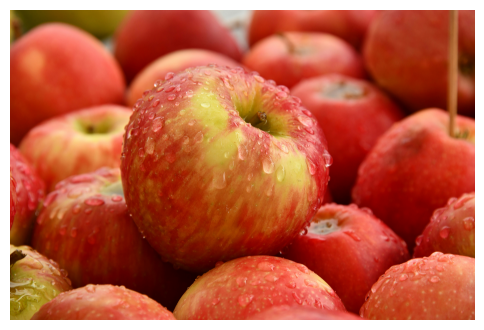

In [9]:
url = "https://images.unsplash.com/photo-1567306226416-28f0efdc88ce"
image = Image.open(requests.get(url, stream=True).raw)
image_np = np.array(image)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.show()

In [10]:
text_prompt = input("Enter text prompt for segmentation: ")
print("Text Prompt:", text_prompt)

Enter text prompt for segmentation: Apple
Text Prompt: Apple


In [11]:
inputs = processor(images=image, return_tensors="pt")
out = model.generate(**inputs)
generated_caption = processor.decode(out[0], skip_special_tokens=True)
print("BLIP Generated Caption:", generated_caption)

BLIP Generated Caption: a close up of a bunch of apples


In [12]:
h, w = image_np.shape[:2]
points = np.array([[w//2, h//2]])
labels = np.array([1])

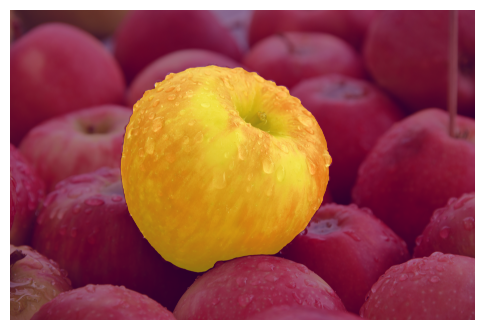

In [13]:
predictor.set_image(image_np)
masks, _, _ = predictor.predict(
    point_coords=points,
    point_labels=labels,
    multimask_output=False
)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.imshow(masks[0], alpha=0.5)
plt.axis("off")
plt.show()

In [ ]:
video_path = "/content/106689-673786365_small.mp4"
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_masked_video.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS),
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
ret, frame = cap.read()
h, w, _ = frame.shape
points = np.array([[w//2, h//2]])
labels = np.array([1])
predictor.set_image(frame)
mask, _, _ = predictor.predict(point_coords=points, point_labels=labels, multimask_output=False)
mask = mask[0]
while ret:
    overlay = frame.copy()
    overlay[mask>0] = [0, 255, 0]
    blended = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)
    out.write(blended)

    ret, frame = cap.read()
    if ret:
        predictor.set_image(frame)
        mask, _, _ = predictor.predict(point_coords=points, point_labels=labels, multimask_output=False)
        mask = mask[0]

cap.release()
out.release()
print("Video segmentation saved as 'output_masked_video.mp4'")
